In [ ]:
# Install Pytorch
%pip install torch==2.5.1+cu121 torchvision==0.20.1+cu121 torchaudio==2.5.1+cu121 --index-url https://download.pytorch.org/whl/cu121
# Install Hugging Face libraries
%pip install  --upgrade "transformers==4.40.0" "datasets==2.18.0" "accelerate==0.29.3" "evaluate==0.4.1" "bitsandbytes==0.43.1" "huggingface_hub==0.22.2" "trl==0.8.6" "peft==0.10.0"

In [ ]:
import os
import re
import random
import functools
import csv
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import evaluate
import bitsandbytes

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score

from datasets import Dataset, DatasetDict
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model

from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)


In [4]:
%cd ..

c:\Users\lh5938a\Desktop\CTP


In [5]:
df = pd.read_csv("Data/llama/parsed_trials_5000_llama.csv")
df.head()

,trial_information,result
0,TRIAL NAME: Phase II - w/Pembrolizumab (TNBC/T...,No
1,TRIAL NAME: Phase I - Safety/PK; BRIEF: The pu...,No
2,TRIAL NAME: Phase III - Open-Label Extension (...,Yes
3,TRIAL NAME: Phase II - M13-608 (CIAS); BRIEF: ...,No
4,TRIAL NAME: Phase II - w/Ruxolitinib (MF/Post-...,Yes


In [ ]:
def structure_trial_information(text):
    """
    Keep original phase information but structure consistently
    """
    
    if 'BRIEF:' in text:
        name, brief = text.split('BRIEF:', 1)
        name = name.strip(' ;')
        brief = brief.strip()
        
        return f"{name}\nBrief Description: {brief}"
    
    return text

df['trial_information'] = df['trial_information'].apply(structure_trial_information)

print("\nExample structured text:")
print(df['trial_information'].iloc[0])


Example structured text:
TRIAL NAME: Phase II - w/Pembrolizumab (TNBC/TN-IBC)
Brief Description: This is an open label, single arm, multi-centre phase II study to assess the anti-tumour activity and safety of bemcentinib (BGB324) in combination with pembrolizumab in participants with previously treated, locally advanced and unresectable, or metastatic TNBC or TN-IBC. The primary objective is objective response rate. ; DRUG USED: Bemcentinib; DRUG CLASS: New Molecular Entity (NME); INDICATION: Breast Cancer; TARGET: Axl Receptor Tyrosine Kinase; THERAPY: Combination; LEAD SPONSOR: BerGenBio ASA; CRITERIA: Inclusion Criteria: 1. Provision of signed informed consent. 2. Male and non-pregnant females who are aged 18 years or older at the time of provision of informed consent. 3. Histopathologically or cytologically documented TNBC or TN-IBC. Tumors must have been confirmed negative for ER and partial response (PR) by immunohistochemistry (IHC) (<1% positive tumor nuclei, as per ASCO-CAP g

In [ ]:
def extract_phase_number(text):
    if "Phase I" in text and "Phase II" not in text and "Phase III" not in text:
        return 1
    elif "Phase II" in text and "Phase III" not in text:
        return 2
    elif "Phase III" in text:
        return 3
    return 0 

df['phase'] = df['trial_information'].apply(extract_phase_number)

print("\nPhase Distribution:")
print(df['phase'].value_counts())
print("\nSuccess Rate by Phase:")
for phase in [1, 2, 3]:
    phase_data = df[df['phase'] == phase]
    success_rate = (phase_data['result'] == 'Yes').mean()
    print(f"Phase {phase}: {success_rate:.2%} ({len(phase_data)} trials)")


Phase Distribution:
phase
2    2016
1    1569
3    1412
0       3
Name: count, dtype: int64

Success Rate by Phase:
Phase 1: 44.87% (1569 trials)
Phase 2: 43.01% (2016 trials)
Phase 3: 66.86% (1412 trials)


In [ ]:
HF_TOKEN='your_HF_token'

In [ ]:
from huggingface_hub import login
import os

login(token=HF_TOKEN)

In [8]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU count: {torch.cuda.device_count()}")

PyTorch version: 2.5.1+cu121
CUDA available: True
GPU count: 2


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "TsinghuaC3I/Llama-3-8B-UltraMedical"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16).cuda()

model.eval()


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 4/4 [00:36<00:00,  9.13s/it]


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head)

In [ ]:
import tqdm

In [36]:

def classify_trial_simple(model, tokenizer, trial_information, max_length=512):
    sys_message = (
        "You are a strict binary classifier for clinical trial phase predictions.",
         "Always respond with a single word: 'yes' or 'no.' Do not include any other tokens or metadata in your response.",
    )
    question = f"""Analyze clinical trials and predict advancement to next phase.

    Example 1: 
    Trial: Phase 2 study testing a new cancer drug with a clear primary endpoint, robust safety data, and compelling preliminary efficacy results. The trial design aligns with regulatory expectations, and patient recruitment is feasible. 
    Prediction: Yes

    Example 2: 
    Trial: Phase 1 study evaluating an experimental therapy with vague endpoints, safety signals from prior studies indicating significant risks, and no well-defined patient population or target. 
    Prediction: No

    Example 3: 
    Trial: Phase 3 trial in a rare disease with a large unmet need, utilizing a validated biomarker as the primary endpoint. Previous phase data demonstrated strong efficacy and manageable safety concerns. 
    Prediction: Yes

    Example 4: 
    Trial: Phase 2 trial with a poorly justified mechanism of action, unclear protocol, and historical issues with patient recruitment. No prior data to support feasibility. 
    Prediction: No

    
    Now analyze this trial:
    {trial_information}

    Rules:
    1. Answer ONLY with the prediction (Yes/No) 
    2. Do NOT explain or continue the text
    3. Do NOT ask questions
    4. Do NOT write code

    Required format (use exactly this line):
    Prediction:
    """
    messages = [
        {"role": "system", "content": sys_message},
        {"role": "user", "content": question}
    ]
    
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(
        **inputs,
        max_new_tokens=3,  # Limit to concise output
        temperature=0.0,   # Deterministic response
        top_k=1            # Focus on top choice
    )
    
    response_text = tokenizer.batch_decode(outputs)[0].strip()
    answer = response_text.split('<|im_start|>assistant')[-1].strip().lower()
    # print(answer)

    def clean_response(output):
        # Remove unwanted tokens and normalize output
        response = output.lower().strip()
        response = response.replace("<|eot_id|>", "").replace("<|start_header_id|>", "").replace("<|end_header_id|>", "")
        response = response.split()[-1].rstrip('.')
        print(response)

        # Validate response
        if response in {"yes", "no"}:
            return response
        return "unknown"


    return clean_response(answer)


In [ ]:
def test_model(df, num_trials):
    trials_df = df.head(num_trials)
    results = []
    
    for index, trial_row in tqdm.tqdm(trials_df.iterrows(), total=len(trials_df)):
        try:
            prediction = classify_trial_simple(
                model, tokenizer, trial_row["trial_information"]
            )
            results.append({
                "trial_id": index,
                "prediction": prediction,
                "true_label": trial_row.get('result', 'Unknown')
            })
        except Exception as e:
            print(f"Error processing trial {index}: {str(e)}")
            results.append({
                "trial_id": index,
                "prediction": "error",
                "true_label": trial_row.get('result', 'Unknown')
            })
            
    results_df = pd.DataFrame(results)
    print("\nDistribution of predictions:")
    print(results_df['prediction'].value_counts())
    print("\nResults Summary:")
    print(results_df)
    return results_df

# Run the test
results_df = test_model(df, num_trials=1000)
print("\nResults Summary:")
print(results_df)

In [38]:
results_df

,trial_id,prediction,true_label
0,0,no,No
1,1,no,No
2,2,yes,Yes
3,3,no,No
4,4,no,Yes
...,...,...,...
995,995,no,Yes
996,996,yes,Yes
997,997,yes,No
998,998,no,No


In [ ]:
def extract_phase_number(text):
    if "Phase I" in text and "Phase II" not in text and "Phase III" not in text:
        return 1
    elif "Phase II" in text and "Phase III" not in text:
        return 2
    elif "Phase III" in text:
        return 3
    return 0  

def add_phase_to_results(results_df, original_df):
    """
    Add phase information to the results DataFrame by matching trial_ids with the original data.
    
    Parameters:
    results_df (pd.DataFrame): DataFrame with predictions and true labels
    original_df (pd.DataFrame): Original DataFrame containing trial_information
    
    Returns:
    pd.DataFrame: Results DataFrame with added phase column
    """
    enhanced_results = results_df.copy()
    
    trial_info = original_df.loc[results_df['trial_id']]['trial_information']
    
    enhanced_results['phase'] = trial_info.apply(extract_phase_number)
    
    return enhanced_results

phase_results_df = add_phase_to_results(results_df, df)

C:\Users\lh5938a\AppData\Local\Temp\ipykernel_20540\1870977734.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


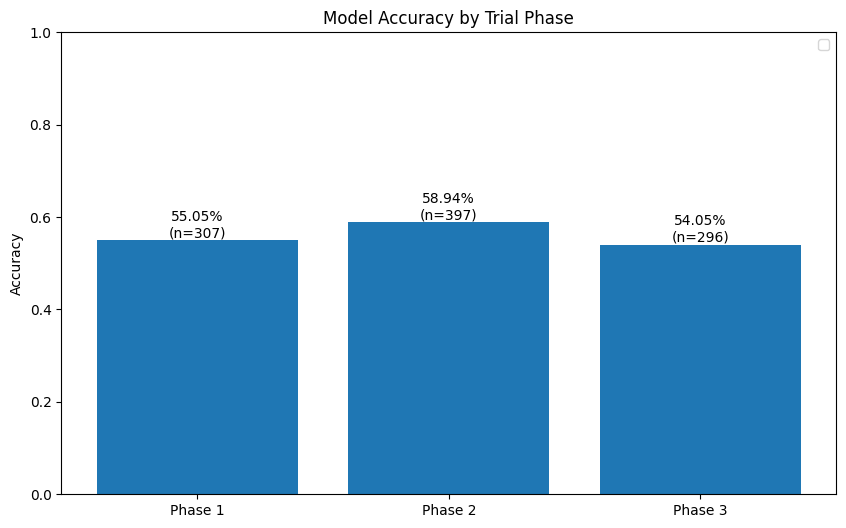


Overall Accuracy: 56.30%
Total samples: 1000
Error count: 0


In [ ]:
def calculate_accuracy_with_visualization(results_df):
    """
    Calculate accuracy and visualize it by phase using matplotlib.
    """
    import matplotlib.pyplot as plt
    
    # Calculate overall accuracy first
    valid_predictions = results_df[results_df['prediction'] != 'error']
    total_samples = len(valid_predictions)
    correct_predictions = (
        valid_predictions['prediction'].str.lower() == 
        valid_predictions['true_label'].str.lower()
    ).sum()    
    overall_accuracy = correct_predictions / total_samples if total_samples > 0 else 0
    
    # Calculate accuracy by phase
    phase_metrics = {}
    for phase in sorted(results_df['phase'].unique()):
        phase_data = results_df[results_df['phase'] == phase]
        phase_valid = phase_data[phase_data['prediction'] != 'error']
        if len(phase_valid) > 0:
            phase_correct = (
                phase_valid['prediction'].str.lower() == 
                phase_valid['true_label'].str.lower()
            ).sum()
            phase_accuracy = phase_correct / len(phase_valid)
            phase_metrics[f'Phase {phase}'] = {
                'accuracy': phase_accuracy,
                'samples': len(phase_valid)
            }
    
    plt.figure(figsize=(10, 6))
    
    phases = list(phase_metrics.keys())
    accuracies = [phase_metrics[phase]['accuracy'] for phase in phases]
    sample_sizes = [phase_metrics[phase]['samples'] for phase in phases]
    
    bars = plt.bar(phases, accuracies)
    

    
    plt.title('Model Accuracy by Trial Phase')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.0)  
    
    for bar, sample_size in zip(bars, sample_sizes):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2%}\n(n={sample_size})',
                ha='center', va='bottom')
    
    plt.legend()
    plt.show()
    
    metrics = {
        'overall': {
            'accuracy': overall_accuracy,
            'correct_predictions': correct_predictions,
            'total_samples': total_samples,
            'error_count': len(results_df) - total_samples
        },
        'by_phase': phase_metrics
    }
    
    return metrics

metrics = calculate_accuracy_with_visualization(phase_results_df)

print(f"\nOverall Accuracy: {metrics['overall']['accuracy']:.2%}")
print(f"Total samples: {metrics['overall']['total_samples']}")
print(f"Error count: {metrics['overall']['error_count']}")

ZERO SHOT

In [ ]:
def classify_trial_simple(model, tokenizer, trial_information, max_length=512):
    sys_message = (
        "You are a strict binary classifier for clinical trial phase predictions.",
         "Always respond with a single word: 'yes' or 'no.' Do not include any other tokens or metadata in your response.",
    )
    question = f"""Will this trial continue to the next phase? Respond with only 'yes' or 'no.' Trial details: {trial_information}"""
        
    messages = [
        {"role": "system", "content": sys_message},
        {"role": "user", "content": question}
    ]
    
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(
        **inputs,
        max_new_tokens=2, 
        temperature=0.0,   
        top_k=1          
    )
    
    response_text = tokenizer.batch_decode(outputs)[0].strip()
    answer = response_text.split('<|im_start|>assistant')[-1].strip().lower()

    def clean_response(output):
        response = output.lower().strip()
        response = response.replace("<|eot_id|>", "").replace("<|start_header_id|>", "").replace("<|end_header_id|>", "")
        response = response.split()[-1].rstrip('.')
        

        if response in {"yes", "no"}:
            return response
        return "unknown"


    return clean_response(answer)

In [ ]:
def test_model(df, num_trials):
    trials_df = df.head(num_trials)
    results = []
    
    for index, trial_row in tqdm.tqdm(trials_df.iterrows(), total=len(trials_df)):
        try:
            prediction = classify_trial_simple(
                model, tokenizer, trial_row["trial_information"]
            )
            results.append({
                "trial_id": index,
                "prediction": prediction,
                "true_label": trial_row.get('result', 'Unknown')
            })
        except Exception as e:
            print(f"Error processing trial {index}: {str(e)}")
            results.append({
                "trial_id": index,
                "prediction": "error",
                "true_label": trial_row.get('result', 'Unknown')
            })
            
    results_df = pd.DataFrame(results)
    print("\nDistribution of predictions:")
    print(results_df['prediction'].value_counts())
    print("\nResults Summary:")
    print(results_df)
    return results_df

zero_shot_results_df = test_model(df, num_trials=1000)
print("\nResults Summary:")
print(zero_shot_results_df)

In [ ]:
def extract_phase_number(text):
    if "Phase I" in text and "Phase II" not in text and "Phase III" not in text:
        return 1
    elif "Phase II" in text and "Phase III" not in text:
        return 2
    elif "Phase III" in text:
        return 3
    return 0 

def add_phase_to_results(results_df, original_df):
    """
    Add phase information to the results DataFrame by matching trial_ids with the original data.
    
    Parameters:
    results_df (pd.DataFrame): DataFrame with predictions and true labels
    original_df (pd.DataFrame): Original DataFrame containing trial_information
    
    Returns:
    pd.DataFrame: Results DataFrame with added phase column
    """
    enhanced_results = results_df.copy()
    
    trial_info = original_df.loc[results_df['trial_id']]['trial_information']
    
    enhanced_results['phase'] = trial_info.apply(extract_phase_number)
    
    return enhanced_results

phase_zero_shot_results_df = add_phase_to_results(zero_shot_results_df, df)

C:\Users\lh5938a\AppData\Local\Temp\ipykernel_20540\1316300458.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


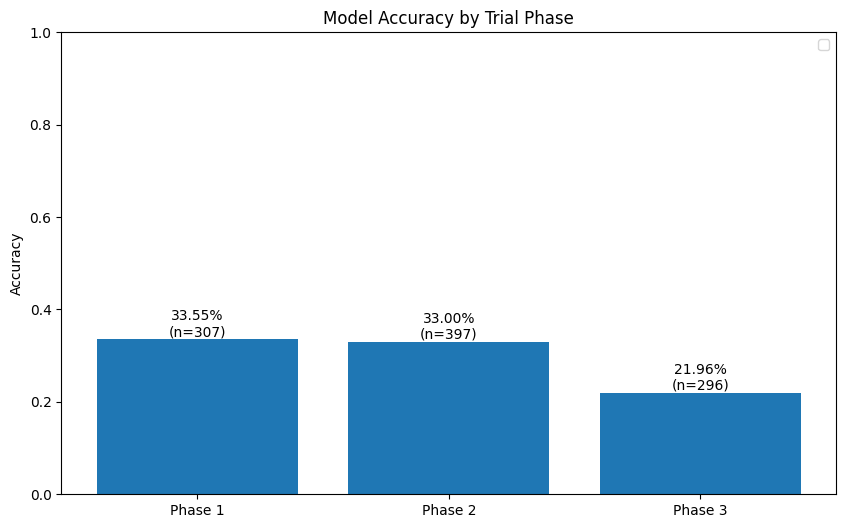


Overall Accuracy: 29.90%
Total samples: 1000
Error count: 0


In [ ]:
def calculate_accuracy_with_visualization(results_df):
    """
    Calculate accuracy and visualize it by phase using matplotlib.
    """
    import matplotlib.pyplot as plt
    
    valid_predictions = results_df[results_df['prediction'] != 'error']
    total_samples = len(valid_predictions)
    correct_predictions = (
        valid_predictions['prediction'].str.lower() == 
        valid_predictions['true_label'].str.lower()
    ).sum()    
    overall_accuracy = correct_predictions / total_samples if total_samples > 0 else 0
    
    phase_metrics = {}
    for phase in sorted(results_df['phase'].unique()):
        phase_data = results_df[results_df['phase'] == phase]
        phase_valid = phase_data[phase_data['prediction'] != 'error']
        if len(phase_valid) > 0:
            phase_correct = (
                phase_valid['prediction'].str.lower() == 
                phase_valid['true_label'].str.lower()
            ).sum()
            phase_accuracy = phase_correct / len(phase_valid)
            phase_metrics[f'Phase {phase}'] = {
                'accuracy': phase_accuracy,
                'samples': len(phase_valid)
            }
    
    plt.figure(figsize=(10, 6))
    
    phases = list(phase_metrics.keys())
    accuracies = [phase_metrics[phase]['accuracy'] for phase in phases]
    sample_sizes = [phase_metrics[phase]['samples'] for phase in phases]
    
    bars = plt.bar(phases, accuracies)
    

    
    plt.title('Model Accuracy by Trial Phase')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.0) 
    
    for bar, sample_size in zip(bars, sample_sizes):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2%}\n(n={sample_size})',
                ha='center', va='bottom')
    
    plt.legend()
    plt.show()
    
    metrics = {
        'overall': {
            'accuracy': overall_accuracy,
            'correct_predictions': correct_predictions,
            'total_samples': total_samples,
            'error_count': len(results_df) - total_samples
        },
        'by_phase': phase_metrics
    }
    
    return metrics

metrics = calculate_accuracy_with_visualization(phase_zero_shot_results_df)

print(f"\nOverall Accuracy: {metrics['overall']['accuracy']:.2%}")
print(f"Total samples: {metrics['overall']['total_samples']}")
print(f"Error count: {metrics['overall']['error_count']}")